<a href="https://colab.research.google.com/github/rakeshgovindsuresh/Python-Practice/blob/main/finalcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the datasets
deliveries_df = pd.read_csv('/content/deliveries.csv')
matches_df = pd.read_csv('/content/matches.csv')

# Merge the deliveries data with the matches data on 'match_id'
cleaned_df = pd.merge(deliveries_df, matches_df, on='match_id', how='inner')

cleaned_df = cleaned_df[['match_id', 'season', 'venue', 'team1', 'team2',
                         'result_margin', 'target_runs', 'target_overs', 'super_over',
                         'inning', 'batting_team', 'bowling_team', 'over', 'ball',
                         'batter', 'bowler', 'non_striker', 'batsman_runs', 'extra_runs',
                         'total_runs', 'extras_type', 'is_wicket']]

# Export the merged dataset to a CSV file
cleaned_df.to_csv('/content/recreated_cleaned_dataset.csv', index=False)


In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/recreated_cleaned_dataset.csv'  # Replace with the actual path to your dataset
dataset = pd.read_csv(file_path)

# 1. Batsman Statistics

# Total Runs, Balls Faced, Number of 4s and 6s
batsman_stats = dataset.groupby('batter').agg(
    total_runs=('batsman_runs', 'sum'),
    balls_faced=('ball', 'count'),
    fours=('batsman_runs', lambda x: (x == 4).sum()),
    sixes=('batsman_runs', lambda x: (x == 6).sum())
).reset_index()

# Calculate Strike Rate for Batsman
batsman_stats['strike_rate'] = (batsman_stats['total_runs'] / batsman_stats['balls_faced']) * 100

# 2. Bowler Statistics

# Total Wickets, Runs Conceded, and Balls Bowled (to calculate overs)
bowler_stats = dataset.groupby('bowler').agg(
    total_wickets=('is_wicket', 'sum'),
    runs_conceded=('total_runs', 'sum'),
    balls_bowled=('ball', 'count')
).reset_index()

# Calculate Overs Bowled and Economy Rate
bowler_stats['overs_bowled'] = bowler_stats['balls_bowled'] / 6
bowler_stats['economy_rate'] = bowler_stats['runs_conceded'] / bowler_stats['overs_bowled']

# 3. Batsman vs. Bowler Comparison

# Average Runs per Ball (Batsman vs. Bowler)
batsman_bowler_avg_runs = dataset.groupby(['batter', 'bowler'])['batsman_runs'].mean().reset_index()
batsman_bowler_avg_runs.columns = ['batter', 'bowler', 'avg_runs_per_ball_batsman_vs_bowler']

# Strike Rate (Batsman vs. Bowler)
batsman_bowler_stats = dataset.groupby(['batter', 'bowler']).agg(
    total_runs=('batsman_runs', 'sum'),
    total_balls=('ball', 'count')
).reset_index()
batsman_bowler_stats['strike_rate_batsman_vs_bowler'] = (batsman_bowler_stats['total_runs'] / batsman_bowler_stats['total_balls']) * 100

# Dismissal Rate (Batsman vs. Bowler)
dismissals = dataset[dataset['is_wicket'] == 1].groupby(['batter', 'bowler']).size().reset_index(name='dismissals')
dismissal_rate = dismissals.merge(batsman_bowler_stats[['batter', 'bowler', 'total_balls']], on=['batter', 'bowler'])
dismissal_rate['dismissal_rate_batsman_vs_bowler'] = dismissal_rate['total_balls'] / dismissal_rate['dismissals']

# 4. Percentage of Runs Distribution per Batsman vs. Bowler

# Calculate the percentage of balls that resulted in 6s, 4s, 3s, 2s, 1s, and 0 runs
runs_distribution = dataset.groupby(['batter', 'bowler', 'batsman_runs']).size().unstack(fill_value=0).reset_index()

# Calculate percentages for each type of run
numeric_columns = runs_distribution.select_dtypes(include='number').columns  # Only sum numeric columns
total_balls_faced = runs_distribution[numeric_columns].sum(axis=1)
runs_distribution['percent_6s'] = (runs_distribution[6] / total_balls_faced) * 100
runs_distribution['percent_4s'] = (runs_distribution[4] / total_balls_faced) * 100
runs_distribution['percent_3s'] = (runs_distribution[3] / total_balls_faced) * 100
runs_distribution['percent_2s'] = (runs_distribution[2] / total_balls_faced) * 100
runs_distribution['percent_1s'] = (runs_distribution[1] / total_balls_faced) * 100
runs_distribution['percent_0s'] = (runs_distribution[0] / total_balls_faced) * 100

# Calculate the percentage of dismissals
dismissal_percentage = dismissal_rate.copy()
dismissal_percentage['percent_dismissals'] = (dismissal_percentage['dismissals'] / dismissal_percentage['total_balls']) * 100

# Merge percentage distributions with the main batsman-bowler comparison DataFrame
batsman_bowler_comparison = batsman_bowler_avg_runs.merge(
    batsman_bowler_stats[['batter', 'bowler', 'strike_rate_batsman_vs_bowler']],
    on=['batter', 'bowler']
).merge(
    dismissal_rate[['batter', 'bowler', 'dismissal_rate_batsman_vs_bowler']],
    on=['batter', 'bowler'], how='left'
).merge(
    runs_distribution[['batter', 'bowler', 'percent_6s', 'percent_4s', 'percent_3s', 'percent_2s', 'percent_1s', 'percent_0s']],
    on=['batter', 'bowler'], how='left'
).merge(
    dismissal_percentage[['batter', 'bowler', 'percent_dismissals']],
    on=['batter', 'bowler'], how='left'
)

# 5. Contextual Features

# Over Context (Powerplay, Middle Overs, Death Overs)
def categorize_over(over):
    if over <= 6:
        return 'Powerplay'
    elif over <= 15:
        return 'Middle Overs'
    else:
        return 'Death Overs'

dataset['over_context'] = dataset['over'].apply(categorize_over)

# Required Run Rate
dataset['required_run_rate'] = (dataset['target_runs'] - dataset.groupby('match_id')['total_runs'].cumsum()) / (dataset['target_overs'] * 6 - dataset.groupby('match_id')['ball'].cumsum())

# Current Run Rate
dataset['current_run_rate'] = dataset.groupby('match_id')['total_runs'].cumsum() / (dataset['over'] + dataset['ball'] / 6)

# Wickets in Hand
dataset['wickets_in_hand'] = 10 - dataset.groupby('match_id')['is_wicket'].cumsum()

# 6. Batsman’s Recent Form Features

# Batsman’s Recent Average Runs
def calculate_recent_average(df, window=20):
    df['recent_avg_runs'] = df.groupby('batter')['batsman_runs'].rolling(window).mean().reset_index(level=0, drop=True)
    return df

dataset = calculate_recent_average(dataset)

# Batsman’s Recent Boundary Rate
def calculate_recent_boundaries(df, window=20):
    df['is_boundary'] = df['batsman_runs'].isin([4, 6])
    df['recent_boundary_rate'] = df.groupby('batter')['is_boundary'].rolling(window).mean().reset_index(level=0, drop=True)
    return df

dataset = calculate_recent_boundaries(dataset)

# 7. Bowler’s Recent Performance Features

# Bowler’s Recent Economy Rate
def calculate_recent_economy(df, window=12):  # Assuming an over contains 6 balls
    df['recent_runs_conceded'] = df.groupby('bowler')['total_runs'].rolling(window).sum().reset_index(level=0, drop=True)
    df['recent_economy_rate'] = df['recent_runs_conceded'] / (window / 6)
    return df

dataset = calculate_recent_economy(dataset)

# Bowler’s Recent Wicket-Taking Ability
def calculate_recent_wickets(df, window=12):
    df['recent_wickets'] = df.groupby('bowler')['is_wicket'].rolling(window).sum().reset_index(level=0, drop=True)
    return df

dataset = calculate_recent_wickets(dataset)

# 8. Partnership Information

# Calculate Partnership Runs and Partnership Balls Faced
dataset['partnership_runs'] = dataset.groupby(['match_id', 'inning', 'batting_team'])['total_runs'].cumsum() - dataset['batsman_runs']
dataset['partnership_balls_faced'] = dataset.groupby(['match_id', 'inning', 'batting_team']).cumcount() + 1

# 9. Match Pressure Metrics

# Pressure Factor = Required Run Rate / (Wickets in Hand + 1)
dataset['pressure_factor'] = dataset['required_run_rate'] / (dataset['wickets_in_hand'] + 1)

# Merge Everything into One DataFrame

# Merge batsman stats
final_dataset = dataset.merge(batsman_stats, left_on='batter', right_on='batter', how='left')

# Merge bowler stats
final_dataset = final_dataset.merge(bowler_stats, left_on='bowler', right_on='bowler', how='left')

# Merge batsman vs. bowler comparison
final_dataset = final_dataset.merge(batsman_bowler_comparison, on=['batter', 'bowler'], how='left')

# Save the final dataset to a CSV file
final_file_path = '/content/NEWFeatureEngdataset.csv'
final_dataset.to_csv(final_file_path, index=False)

print(f"The final combined dataset has been saved as {final_file_path}")



<ipython-input-31-3e478cb769e1>:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file_path)


The final combined dataset has been saved as /content/NEWFeatureEngdataset.csv


In [ ]:
import pandas as pd

# Load the datasets
df_csv = pd.read_csv('/content/NEWFeatureEngdataset.csv', dtype=str, low_memory=False)
df_excel = pd.read_excel('/content/Stadium statistics.xlsx')

# Strip any whitespace from the 'venue' column and convert to lowercase for consistent merging
df_csv['venue'] = df_csv['venue'].str.strip().str.lower()
df_excel['venue'] = df_excel['venue'].str.strip().str.lower()

# Prefix all columns from df_excel except 'venue' with 'venue_'
df_excel = df_excel.rename(columns=lambda x: f"venue_{x}" if x != 'venue' else x)

# Check for unique values in the 'venue' column to identify any mismatches
print("Unique venues in CSV file:", df_csv['venue'].unique())
print("Unique venues in Excel file:", df_excel['venue'].unique())

# Merge the datasets (left join to preserve all rows from df_csv)
merged_df = pd.merge(df_csv, df_excel, on='venue', how='left')

# Save the merged DataFrame
merged_df.to_excel('newmergedFeaturePlusVenueStats.xlsx', index=False)
merged_df.to_csv('newmergedFeaturePlusVenueStats.csv', index=False)

# Print the shape of the merged dataframe to check if rows are preserved
print("Shape of the merged DataFrame:", merged_df.shape)


Unique venues in CSV file: ['m chinnaswamy stadium' 'punjab cricket association stadium, mohali'
 'feroz shah kotla' 'wankhede stadium' 'eden gardens'
 'sawai mansingh stadium' 'rajiv gandhi international stadium, uppal'
 'ma chidambaram stadium, chepauk' 'dr dy patil sports academy' 'newlands'
 "st george's park" 'kingsmead' 'supersport park' 'buffalo park'
 'new wanderers stadium' 'de beers diamond oval' 'outsurance oval'
 'brabourne stadium' 'sardar patel stadium, motera' 'barabati stadium'
 'brabourne stadium, mumbai'
 'vidarbha cricket association stadium, jamtha'
 'himachal pradesh cricket association stadium' 'nehru stadium'
 'holkar cricket stadium'
 'dr. y.s. rajasekhara reddy aca-vdca cricket stadium'
 'subrata roy sahara stadium' 'maharashtra cricket association stadium'
 'shaheed veer narayan singh international stadium'
 'jsca international stadium complex' 'sheikh zayed stadium'
 'sharjah cricket stadium' 'dubai international cricket stadium'
 'punjab cricket association 

In [ ]:
import pandas as pd

# Load the datasets
df_csv = pd.read_csv('/content/newmergedFeaturePlusVenueStats.csv', dtype=str, low_memory=False)


columns_to_drop = ['team1','team2','venue_City','venue_Country','venue_First Match','venue_Last T20 Match','venue_Also or previously Known as','season','super_over','non_striker','venue_Best Bowling','venue_Highest Individual Innings']

df_csv = df_csv.drop(columns=columns_to_drop)

# Check the remaining columns
print(df_csv.columns)

Index(['match_id', 'venue', 'result_margin', 'target_runs', 'target_overs',
       'inning', 'batting_team', 'bowling_team', 'over', 'ball', 'batter',
       'bowler', 'batsman_runs', 'extra_runs', 'total_runs_x', 'extras_type',
       'is_wicket', 'over_context', 'required_run_rate', 'current_run_rate',
       'wickets_in_hand', 'recent_avg_runs', 'is_boundary',
       'recent_boundary_rate', 'recent_runs_conceded', 'recent_economy_rate',
       'recent_wickets', 'partnership_runs', 'partnership_balls_faced',
       'pressure_factor', 'total_runs_y', 'balls_faced', 'fours', 'sixes',
       'strike_rate', 'total_wickets', 'runs_conceded', 'balls_bowled',
       'overs_bowled', 'economy_rate', 'avg_runs_per_ball_batsman_vs_bowler',
       'strike_rate_batsman_vs_bowler', 'dismissal_rate_batsman_vs_bowler',
       'percent_6s', 'percent_4s', 'percent_3s', 'percent_2s', 'percent_1s',
       'percent_0s', 'percent_dismissals', 'venue_Matches Played',
       'venue_Matches Won Batting First

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# List of columns you want to convert to categorical and apply label encoding
columns_to_convert = ['venue', 'batter', 'bowler', 'extras_type', 'over_context', 'is_boundary']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each column
for column in columns_to_convert:
    df_csv[column] = label_encoder.fit_transform(df_csv[column])

# Verify the changes
print(df_csv.dtypes)
output_csv_path = '/content/newfiletocheckconv.csv'  # Replace with your desired output file path
df_csv.to_csv(output_csv_path, index=False)

match_id                             object
venue                                 int64
result_margin                        object
target_runs                          object
target_overs                         object
                                      ...  
venue_Lowest Team Innings            object
venue_Highest Run Chase Achieved     object
venue_Average Runs per Wicket        object
venue_Average Runs per Over          object
venue_Average Score Batting First    object
Length: 62, dtype: object


In [ ]:
import pandas as pd
file_path = "/content/newfiletocheckconv.csv"

df_csv = pd.read_csv(file_path)
columns_to_drop = ['batting_team','bowling_team']
df_csv = df_csv.drop(columns=columns_to_drop)
columns_to_extract = ['venue_Highest Team Innings', 'venue_Lowest Team Innings',
                      'venue_Highest Run Chase Achieved']
for column in columns_to_extract:
    # Extract the numeric part, handle NaN, and convert to integers
    df_csv[column] = df_csv[column].str.extract(r'(\d+)', expand=False)
    df_csv[column] = df_csv[column].fillna(0).astype(int)


# Verify the changes
print(df_csv[columns_to_extract].head())
df_csv.fillna(0, inplace=True)
output_csv_path = '/content/newfullyFeaturedfinalFile.csv'
df_csv.to_csv(output_csv_path, index=False)

<ipython-input-36-d826d685dbed>:4: DtypeWarning: Columns (51,52,53,54,55,56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df_csv = pd.read_csv(file_path)


   venue_Highest Team Innings  venue_Lowest Team Innings  \
0                         287                         82   
1                         287                         82   
2                         287                         82   
3                         287                         82   
4                         287                         82   

   venue_Highest Run Chase Achieved  
0                               186  
1                               186  
2                               186  
3                               186  
4                               186  


In [ ]:
import numpy as np
import pandas as pd

# Load the dataset
file_path = '/content/newfullyFeaturedfinalFile.csv'
df_csv = pd.read_csv(file_path, low_memory=False)

# Initialize a new column for the cumulative runs and required run rate
df_csv['cumulative_runs'] = 0
df_csv['required_run_rate'] = 'N/A'

# Group by each set of innings 1 and 2 representing a match
for match_key, match_data in df_csv.groupby((df_csv['inning'] == 1).cumsum()):
    # Calculate the cumulative runs for inning 2 within each match
    match_data.loc[match_data['inning'] == 2, 'cumulative_runs'] = match_data.loc[match_data['inning'] == 2, 'total_runs_x'].cumsum()

    # Calculate the overs faced as over + (ball / 6)
    match_data['overs_faced'] = match_data['over'] + (match_data['ball'] / 6)

    # Calculate remaining runs and remaining overs only for inning 2
    match_data['remaining_runs'] = np.where(match_data['inning'] == 2,
                                            match_data['target_runs'] - match_data['cumulative_runs'],
                                            np.nan)
    match_data['remaining_overs'] = np.where(match_data['inning'] == 2,
                                             match_data['target_overs'] - match_data['overs_faced'],
                                             np.nan)

    # Calculate the required run rate (RRR) only for inning 2
    match_data['required_run_rate'] = np.where(
        (match_data['inning'] == 2) & (match_data['remaining_overs'] > 0),
        match_data['remaining_runs'] / match_data['remaining_overs'],
        'N/A'  # For inning 1, set RRR to 'N/A'
    )

    # Update the original dataframe with the calculated values
    df_csv.loc[match_data.index, 'cumulative_runs'] = match_data['cumulative_runs']
    df_csv.loc[match_data.index, 'overs_faced'] = match_data['overs_faced']
    df_csv.loc[match_data.index, 'remaining_runs'] = match_data['remaining_runs']
    df_csv.loc[match_data.index, 'remaining_overs'] = match_data['remaining_overs']
    df_csv.loc[match_data.index, 'required_run_rate'] = match_data['required_run_rate']

# Export the updated DataFrame to a new CSV file
output_file_path = '/content/newfullyFeaturedfinalFileUpdated.csv'
df_csv.to_csv(output_file_path, index=False)




In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/newfullyFeaturedfinalFileUpdated.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)

# Filter the DataFrame to keep only rows where 'inning' is 1 or 2
filtered_df = df[(df['inning'] == 1) | (df['inning'] == 2)]

# Save the filtered DataFrame back to a CSV file
output_path = '/content/inningsRemoved.csv'  # Replace with your desired output file path
filtered_df.to_csv(output_path, index=False)

print(f"Filtered data saved to {output_path}")


<ipython-input-42-faf8b73ba5b1>:5: DtypeWarning: Columns (49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Filtered data saved to /content/inningsRemoved.csv


In [ ]:
import pandas as pd

# Load the dataset (adjust the file path)
file_path = '/content/inningsRemoved.csv'
df = pd.read_csv(file_path, low_memory=False)

# Round the 'required_run_rate' and 'current_run_rate' columns to 2 decimal places
df['required_run_rate'] = df['required_run_rate'].round(2)
df['current_run_rate'] = df['current_run_rate'].round(2)

# Fill empty cells in 'required_run_rate' with NaN
df['required_run_rate'] = df['required_run_rate'].replace('', pd.NA)

# Save the updated DataFrame to a new CSV file
df.to_csv('updated_inningsRemoved.csv', index=False)

# Display the first few rows of the modified DataFrame to confirm changes
print(df[['required_run_rate', 'current_run_rate']].head())


   required_run_rate  current_run_rate
0                NaN               6.0
1                NaN               3.0
2                NaN               4.0
3                NaN               3.0
4                NaN               2.4


<ipython-input-44-39e3fc1e1ac8>:6: DtypeWarning: Columns (49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/inningsRemoved.csv')  # Replace with the correct path to your CSV file


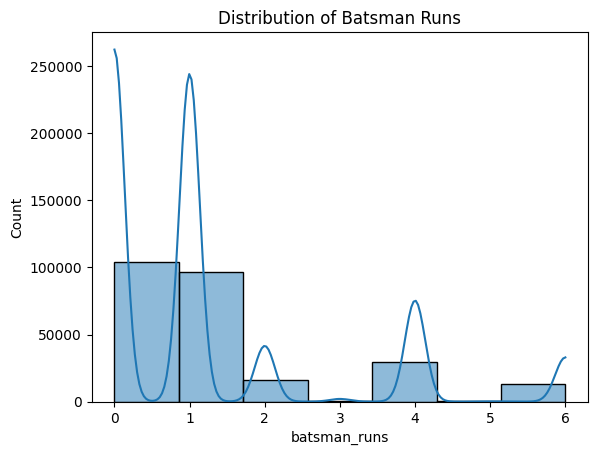

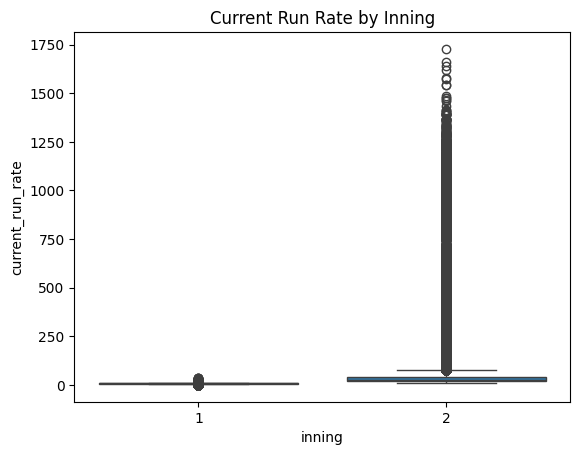

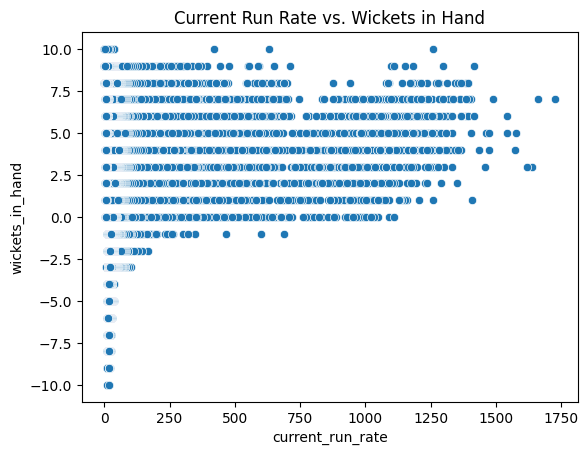

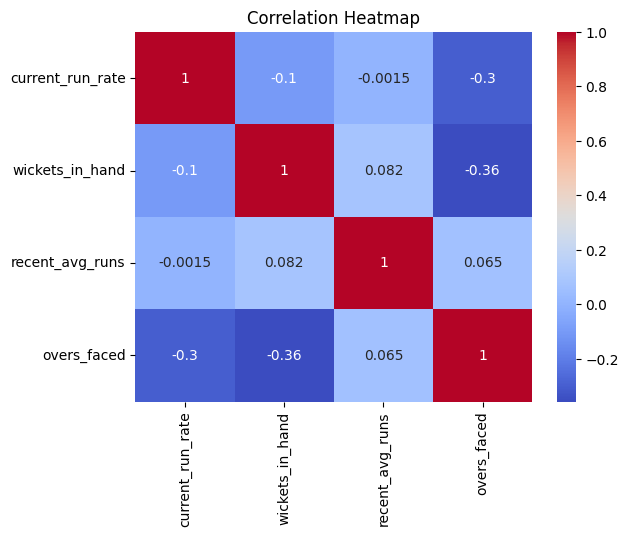

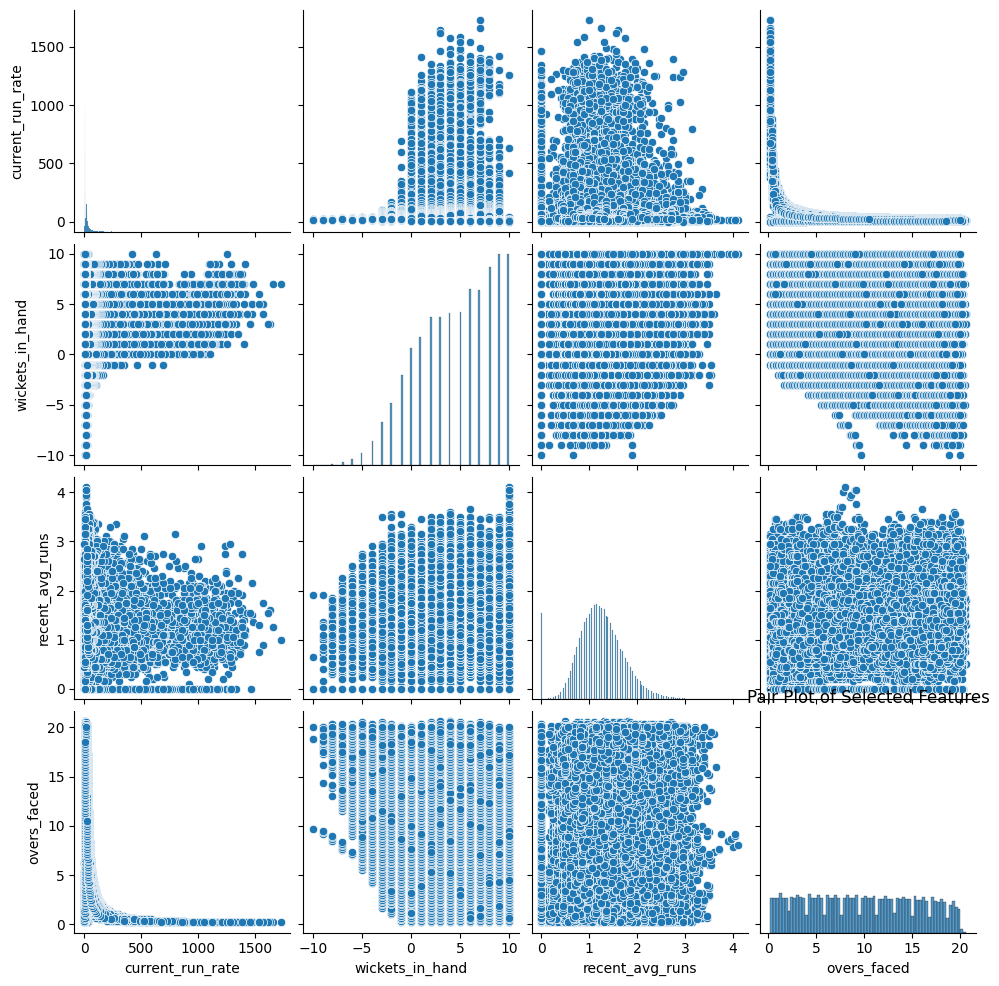

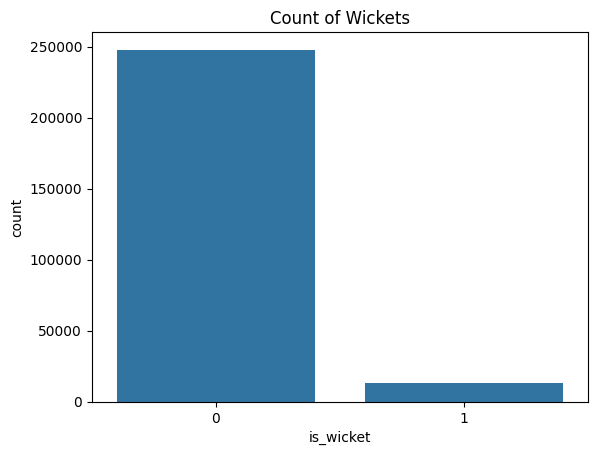

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Replace with the correct path to your CSV file

# 1. Histogram of batsman runs
sns.histplot(data['batsman_runs'], bins=7, kde=True)
plt.title('Distribution of Batsman Runs')
plt.show()

# 2. Box plot of current run rate by innings
sns.boxplot(x='inning', y='current_run_rate', data=data)
plt.title('Current Run Rate by Inning')
plt.show()

# 3. Scatter plot of current run rate vs. wickets in hand
sns.scatterplot(x='current_run_rate', y='wickets_in_hand', data=data)
plt.title('Current Run Rate vs. Wickets in Hand')
plt.show()

# 4. Correlation heatmap of numerical features
corr = data[['current_run_rate', 'wickets_in_hand', 'recent_avg_runs', 'overs_faced']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 5. Pair plot for selected numerical features
sns.pairplot(data[['current_run_rate', 'wickets_in_hand', 'recent_avg_runs', 'overs_faced']])
plt.title('Pair Plot of Selected Features')
plt.show()

# 6. Count plot of wickets
sns.countplot(x='is_wicket', data=data)
plt.title('Count of Wickets')
plt.show()


<ipython-input-45-633da7a2dc06>:4: DtypeWarning: Columns (49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed


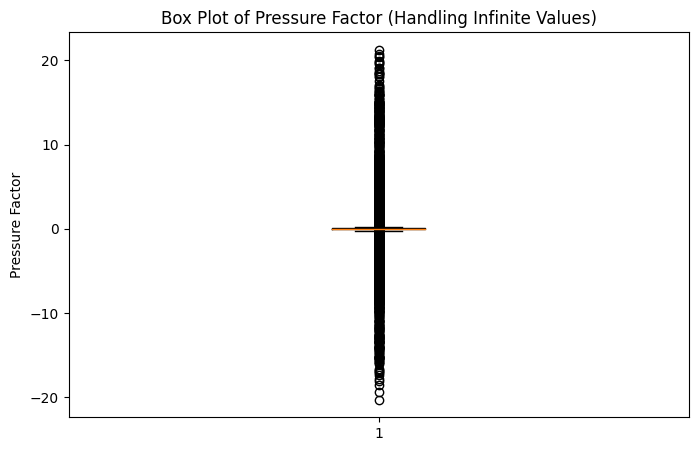

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed
# Assuming your dataframe is called 'data'
# Replace infinite values with NaN to handle them in plotting
data['pressure_factor'] = data['pressure_factor'].replace([np.inf, -np.inf], np.nan)

# Plot a box plot for 'pressure factor'
plt.figure(figsize=(8, 5))
plt.boxplot(data['pressure_factor'].dropna())
plt.title('Box Plot of Pressure Factor (Handling Infinite Values)')
plt.ylabel('Pressure Factor')
plt.show()


<ipython-input-46-1df5417825e3>:8: DtypeWarning: Columns (49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


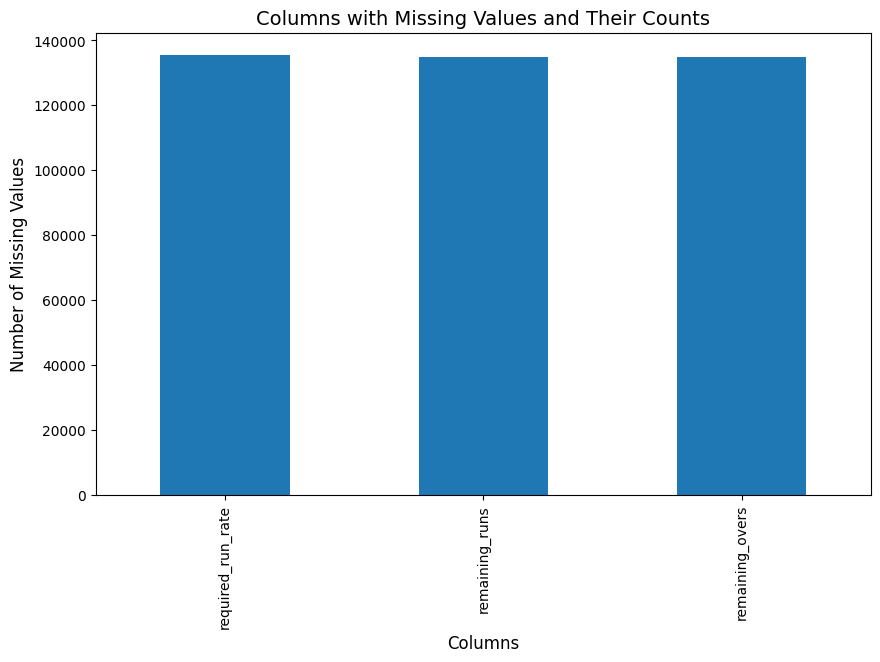

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Load the dataset
file_path = '/content/inningsRemoved.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)
missing_values = df.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(10, 6))
columns_with_missing_values.plot(kind='bar')
plt.title('Columns with Missing Values and Their Counts', fontsize=14)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)
plt.show()

<ipython-input-3-bd19e795212d>:6: DtypeWarning: Columns (49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/inningsRemoved.csv')


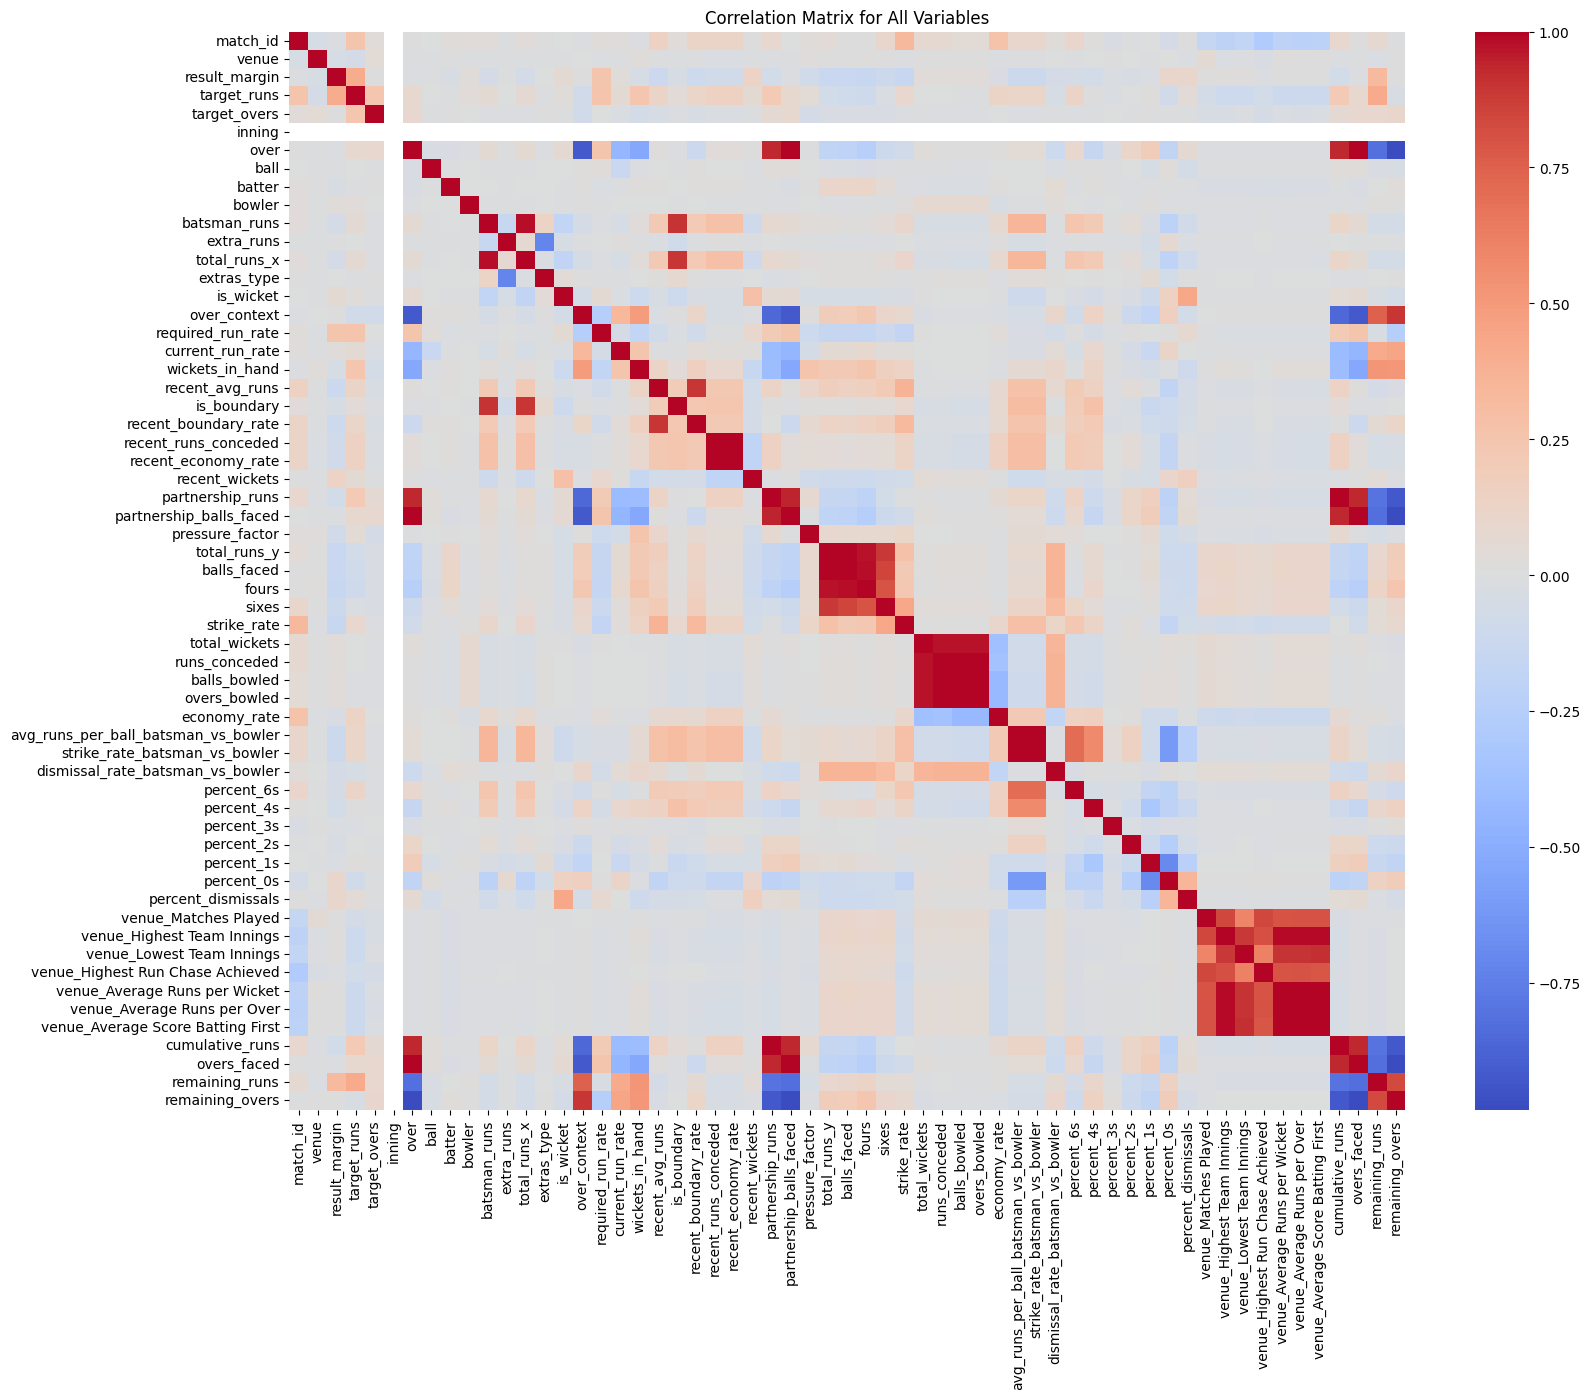

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')

# Select numeric columns for correlation matrix
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Create a subset of the dataframe with numeric columns and drop rows with missing values
subset_data = data[numeric_columns].dropna()

# Calculate the correlation matrix
correlation_matrix = subset_data.corr()

# Plot a larger heatmap for all variables without annotations for better readability
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix for All Variables')
plt.show()


Machine Learning Models

<ipython-input-47-a555935181f9>:13: DtypeWarning: Columns (49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed


Enter the Match ID: 1426311
Enter the Inning Number (1 or 2): 1
Enter the Over Number: 5
Original Target Distribution (up to and including match_id):
target
1          95954
0          78534
4          29676
2          16354
6          12938
W          12911
Bye         8318
Wide        3986
No Ball     1055
3            782
5             65
Leg Bye        2
Name: count, dtype: int64

Resampled Target Distribution (balanced):
target
W          95954
0          95954
1          95954
6          95954
2          95954
4          95954
No Ball    95954
Leg Bye    95954
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
19191/19191 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.5185 - loss: 1.0738 - val_accuracy: 0.5658 - val_loss: 0.9656
Epoch 2/20
19191/19191 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - accuracy: 0.5812 - loss: 0.9241 - val_accuracy: 0.6075 - val_loss: 0.8605
Epoch 3/20
19191/19191 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - accuracy: 0.6131 - loss: 0.8478 - val_accuracy: 0.6243 - val_loss: 0.8188
Epoch 4/20
19191/19191 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.6259 - loss: 0.8119 - val_accuracy: 0.6320 - val_loss: 0.7982
Epoch 5/20
19191/19191 ━━━━━━━━━━━━━━━━━━━━ 86s 3ms/step - accuracy: 0.6347 - loss: 0.7898 - val_accuracy: 0.6298 - val_loss: 0.7879
Epoch 6/20
19191/19191 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step - accuracy: 0.6375 - loss: 0.7804 - val_accuracy: 0.6398 - val_loss: 0.7751
Epoch 7/20
19191/19191 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.6395 - loss: 0.7715 - val_accuracy: 0.6383 - val_loss: 0.7712
Epoch 8/20
19191/19191 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 

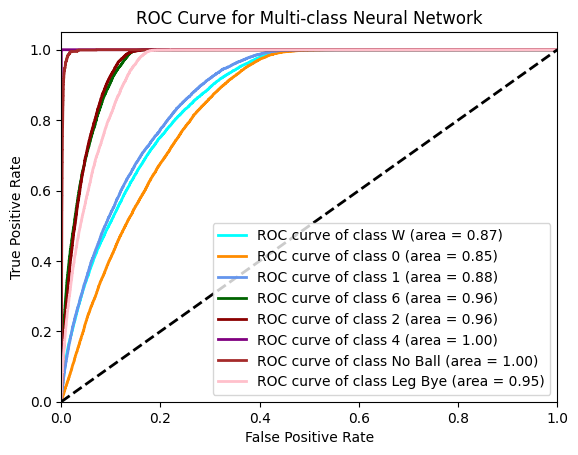


Macro AUC: 0.93


In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import label_binarize

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Function to calculate target (includes runs, extras, and wickets)
def calculate_target(row):
    if row['is_wicket'] == 1:
        return 'W'
    elif row['extras_type'] == 1:  # Wide ball
        return 'Wide'
    elif row['extras_type'] == 2:  # No ball
        return 'No Ball'
    elif row['extras_type'] == 3:  # Leg Bye
        return 'Leg Bye'
    elif row['extras_type'] == 4:  # Bye
        return 'Bye'
    else:
        return str(int(row['batsman_runs']))

# Create target column
data['target'] = data.apply(calculate_target, axis=1)

# Get user inputs for match_id, inning, and over
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Filter the data to include only matches up to and including the specified match_id
historic_data = data[data['match_id'] <= match_id]

# Check if the specified over exists in the dataset
filtered_data = historic_data[(historic_data['match_id'] == match_id) &
                              (historic_data['inning'] == inning) &
                              (historic_data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Create feature and target datasets for all matches up to the specified match_id
    X = historic_data[features]
    y = historic_data['target']

    # Display the original distribution of target classes
    print("Original Target Distribution (up to and including match_id):")
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    classes = ['W', '0', '1', '6', '2', '4', 'No Ball', 'Leg Bye']
    class_data = {cls: data_combined[data_combined['target'] == cls] for cls in classes}

    # Determine the majority class size
    majority_size = max(len(class_data[cls]) for cls in classes)

    # Resample each class to the majority size
    resampled_data = [resample(class_data[cls], replace=True, n_samples=majority_size, random_state=42) for cls in classes]

    # Combine the resampled data
    data_balanced = pd.concat(resampled_data)

    # Separate features and target
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Display the resampled distribution of target classes
    print("\nResampled Target Distribution (balanced):")
    print(y_balanced.value_counts())

    # Normalize the feature data
    scaler = StandardScaler()
    X_balanced_scaled = scaler.fit_transform(X_balanced)

    # Binarize the target variable
    lb = LabelBinarizer()
    y_balanced_binarized = lb.fit_transform(y_balanced)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_balanced_scaled, y_balanced_binarized, test_size=0.2, random_state=42)

    # Build a simple neural network model
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))  # Multi-class output using softmax

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the neural network
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

    # Evaluate the model on the test set
    _, accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

    # Predict probabilities on the test set
    y_pred_prob = model.predict(X_test)

    # Convert predicted probabilities to class labels
    y_pred_class = lb.inverse_transform(y_pred_prob)

    # Classification Report and Confusion Matrix
    y_test_class = lb.inverse_transform(y_test)
    print("\nClassification Report:")
    print(classification_report(y_test_class, y_pred_class))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_class, y_pred_class))

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(y_train.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'darkred', 'purple', 'brown', 'pink']
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-class Neural Network')
    plt.legend(loc="lower right")
    plt.show()

    # Compute AUC for the entire model
    macro_roc_auc = roc_auc_score(y_test, y_pred_prob, average="macro")
    print(f"\nMacro AUC: {macro_roc_auc:.2f}")


<ipython-input-52-e27fc963f865>:11: DtypeWarning: Columns (49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed


Enter the Match ID: 1426311
Enter the Inning Number (1 or 2): 1
Enter the Over Number: 5
Original Target Distribution (up to and including match_id):
target
1          95954
0          78534
4          29676
2          16354
6          12938
W          12911
Bye         8318
Wide        3986
No Ball     1055
3            782
5             65
Leg Bye        2
Name: count, dtype: int64

Resampled Target Distribution (balanced):
target
W          95954
0          95954
1          95954
6          95954
2          95954
4          95954
No Ball    95954
Leg Bye    95954
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:39:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.46      0.52     19122
           1       0.50      0.35      0.41     19182
           2       0.63      0.55      0.59     19272
           4       0.82      0.79      0.81     19190
           6       0.79      0.86      0.82     19239
     Leg Bye       1.00      1.00      1.00     19094
     No Ball       0.89      0.89      0.89     19265
           W       0.57      0.90      0.70     19163

    accuracy                           0.73    153527
   macro avg       0.72      0.73      0.72    153527
weighted avg       0.72      0.73      0.72    153527


Confusion Matrix:
[[ 8856  3314  1713     0     0     0   609  4630]
 [ 3233  6798  3717     0     0     0   758  4676]
 [ 1566  2784 10598     0     0     0   701  3623]
 [    0     0     0 15133  4041     0    16     0]
 [    0     0     0  2769 16450     0    20     0]
 [    0     0     0     0     0 19094     0     0]


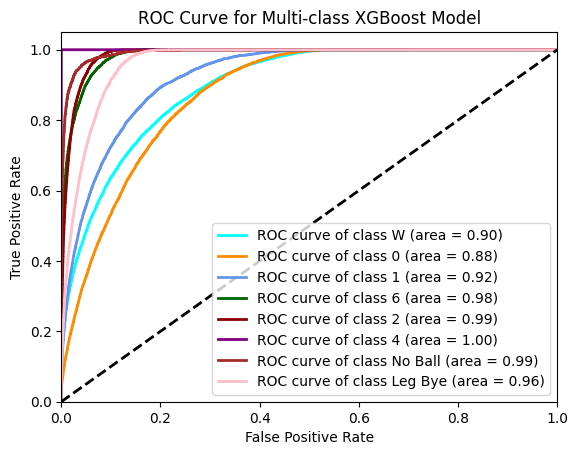


Macro AUC: 0.95


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Function to calculate target (includes runs, extras, and wickets)
def calculate_target(row):
    if row['is_wicket'] == 1:
        return 'W'
    elif row['extras_type'] == 1:  # Wide ball
        return 'Wide'
    elif row['extras_type'] == 2:  # No ball
        return 'No Ball'
    elif row['extras_type'] == 3:  # Leg Bye
        return 'Leg Bye'
    elif row['extras_type'] == 4:  # Bye
        return 'Bye'
    else:
        return str(int(row['batsman_runs']))

# Create target column
data['target'] = data.apply(calculate_target, axis=1)

# Get user inputs for match_id, inning, and over
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Validate the inning input: if it's not 1 or 2, throw an error
if inning not in [1, 2]:
    raise ValueError(f"Inning {inning} is invalid. Only innings 1 or 2 are allowed.")

# Filter the data to include only matches up to and including the specified match_id
historic_data = data[data['match_id'] <= match_id]

# Check if the specified over exists in the dataset
filtered_data = historic_data[(historic_data['match_id'] == match_id) &
                              (historic_data['inning'] == inning) &
                              (historic_data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Create feature and target datasets for all matches up to the specified match_id
    X = historic_data[features]
    y = historic_data['target']

    # Display the original distribution of target classes
    print("Original Target Distribution (up to and including match_id):")
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    classes = ['W', '0', '1', '6', '2', '4', 'No Ball', 'Leg Bye']
    class_data = {cls: data_combined[data_combined['target'] == cls] for cls in classes}

    # Determine the majority class size
    majority_size = max(len(class_data[cls]) for cls in classes)

    # Resample each class to the majority size
    resampled_data = [resample(class_data[cls], replace=True, n_samples=majority_size, random_state=42) for cls in classes]

    # Combine the resampled data
    data_balanced = pd.concat(resampled_data)

    # Separate features and target
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Display the resampled distribution of target classes
    print("\nResampled Target Distribution (balanced):")
    print(y_balanced.value_counts())

    # Normalize the feature data
    scaler = StandardScaler()
    X_balanced_scaled = scaler.fit_transform(X_balanced)

    # Encode target labels as single-label integers
    le = LabelEncoder()
    y_balanced_encoded = le.fit_transform(y_balanced)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_balanced_scaled, y_balanced_encoded, test_size=0.2, random_state=42)

    # Initialize the XGBoost classifier
    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

    # Train the XGBoost model
    xgb_model.fit(X_train, y_train)

    # Predict probabilities on the test set
    y_pred_prob = xgb_model.predict_proba(X_test)

    # Convert predicted probabilities to class labels
    y_pred_class = xgb_model.predict(X_test)

    # Decode the predicted and test labels back to original classes
    y_test_class = le.inverse_transform(y_test)
    y_pred_class_decoded = le.inverse_transform(y_pred_class)

    # Classification Report and Confusion Matrix
    print("\nClassification Report:")
    print(classification_report(y_test_class, y_pred_class_decoded))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_class, y_pred_class_decoded))

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        y_test_bin = np.where(y_test == i, 1, 0)
        y_pred_prob_bin = y_pred_prob[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_test_bin, y_pred_prob_bin)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'darkred', 'purple', 'brown', 'pink']
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-class XGBoost Model')
    plt.legend(loc="lower right")
    plt.show()

    # Compute AUC for the entire model
    macro_roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr", average="macro")
    print(f"\nMacro AUC: {macro_roc_auc:.2f}")


<ipython-input-55-cbe6fb126600>:12: DtypeWarning: Columns (49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed


Enter the Match ID: 1426311
Enter the Inning Number (1 or 2): 1
Enter the Over Number: 5
Original Target Distribution (up to and including match_id):
target
1          95954
0          78534
4          29676
2          16354
6          12938
W          12911
Bye         8318
Wide        3986
No Ball     1055
3            782
5             65
Leg Bye        2
Name: count, dtype: int64

Resampled Target Distribution (balanced):
target
W          95954
0          95954
1          95954
6          95954
2          95954
4          95954
No Ball    95954
Leg Bye    95954
Name: count, dtype: int64
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.334847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1728
[LightGBM] [Info] Number of data points in the train set: 614105, number of used features: 20
[LightGBM] [Info] Start training from score -2.

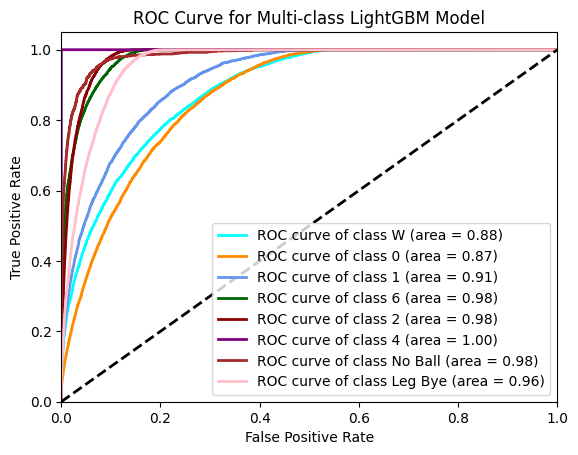


Macro AUC: 0.95


In [ ]:
!pip install lightgbm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
from sklearn.utils import resample

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Function to calculate target (includes runs, extras, and wickets)
def calculate_target(row):
    if row['is_wicket'] == 1:
        return 'W'
    elif row['extras_type'] == 1:  # Wide ball
        return 'Wide'
    elif row['extras_type'] == 2:  # No ball
        return 'No Ball'
    elif row['extras_type'] == 3:  # Leg Bye
        return 'Leg Bye'
    elif row['extras_type'] == 4:  # Bye
        return 'Bye'
    else:
        return str(int(row['batsman_runs']))

# Create target column
data['target'] = data.apply(calculate_target, axis=1)

# Get user inputs for match_id, inning, and over
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Validate the inning input: if it's not 1 or 2, throw an error
if inning not in [1, 2]:
    raise ValueError(f"Inning {inning} is invalid. Only innings 1 or 2 are allowed.")

# Filter the data to include only matches up to and including the specified match_id
historic_data = data[data['match_id'] <= match_id]

# Check if the specified over exists in the dataset
filtered_data = historic_data[(historic_data['match_id'] == match_id) &
                              (historic_data['inning'] == inning) &
                              (historic_data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Create feature and target datasets for all matches up to the specified match_id
    X = historic_data[features]
    y = historic_data['target']

    # Display the original distribution of target classes
    print("Original Target Distribution (up to and including match_id):")
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    classes = ['W', '0', '1', '6', '2', '4', 'No Ball', 'Leg Bye']
    class_data = {cls: data_combined[data_combined['target'] == cls] for cls in classes}

    # Determine the majority class size
    majority_size = max(len(class_data[cls]) for cls in classes)

    # Resample each class to the majority size
    resampled_data = [resample(class_data[cls], replace=True, n_samples=majority_size, random_state=42) for cls in classes]

    # Combine the resampled data
    data_balanced = pd.concat(resampled_data)

    # Separate features and target
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Display the resampled distribution of target classes
    print("\nResampled Target Distribution (balanced):")
    print(y_balanced.value_counts())

    # Normalize the feature data
    scaler = StandardScaler()
    X_balanced_scaled = scaler.fit_transform(X_balanced)

    # Encode target labels as single-label integers
    le = LabelEncoder()
    y_balanced_encoded = le.fit_transform(y_balanced)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_balanced_scaled, y_balanced_encoded, test_size=0.2, random_state=42)

    # Initialize the LightGBM classifier
    lgb_model = lgb.LGBMClassifier(random_state=42)

    # Train the LightGBM model
    lgb_model.fit(X_train, y_train)

    # Predict probabilities on the test set
    y_pred_prob = lgb_model.predict_proba(X_test)

    # Convert predicted probabilities to class labels
    y_pred_class = lgb_model.predict(X_test)

    # Decode the predicted and test labels back to original classes
    y_test_class = le.inverse_transform(y_test)
    y_pred_class_decoded = le.inverse_transform(y_pred_class)

    # Classification Report and Confusion Matrix
    print("\nClassification Report:")
    print(classification_report(y_test_class, y_pred_class_decoded))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_class, y_pred_class_decoded))

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        y_test_bin = np.where(y_test == i, 1, 0)
        y_pred_prob_bin = y_pred_prob[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_test_bin, y_pred_prob_bin)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'darkred', 'purple', 'brown', 'pink']
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-class LightGBM Model')
    plt.legend(loc="lower right")
    plt.show()

    # Compute AUC for the entire model
    macro_roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr", average="macro")
    print(f"\nMacro AUC: {macro_roc_auc:.2f}")


<ipython-input-57-1131bd1c18dd>:14: DtypeWarning: Columns (49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed


Enter the Match ID: 1426311
Enter the Inning Number (1 or 2): 1
Enter the Over Number: 5
Original Target Distribution (up to and including match_id):
target
1          95954
0          78534
4          29676
2          16354
6          12938
W          12911
Bye         8318
Wide        3986
No Ball     1055
3            782
5             65
Leg Bye        2
Name: count, dtype: int64

Resampled Target Distribution (balanced):
target
W          95954
0          95954
1          95954
6          95954
2          95954
4          95954
No Ball    95954
Leg Bye    95954
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [02:07:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81     19122
           1       0.86      0.71      0.78     19182
           2       0.92      0.97      0.94     19272
           4       0.99      0.96      0.98     19190
           6       0.96      0.99      0.98     19239
     Leg Bye       1.00      1.00      1.00     19094
     No Ball       1.00      1.00      1.00     19265
           W       0.82      1.00      0.90     19163

    accuracy                           0.93    153527
   macro avg       0.93      0.93      0.92    153527
weighted avg       0.93      0.93      0.92    153527


Confusion Matrix:
[[14778  2072   553     0     0    29    36  1654]
 [ 2419 13647  1111     0     0    40    34  1931]
 [   64    51 18685     0     0     2     0   470]
 [    0     0     0 18440   750     0     0     0]
 [    0     0     0   134 19105     0     0     0]
 [    0     0     0     0     0 19094     0     0]


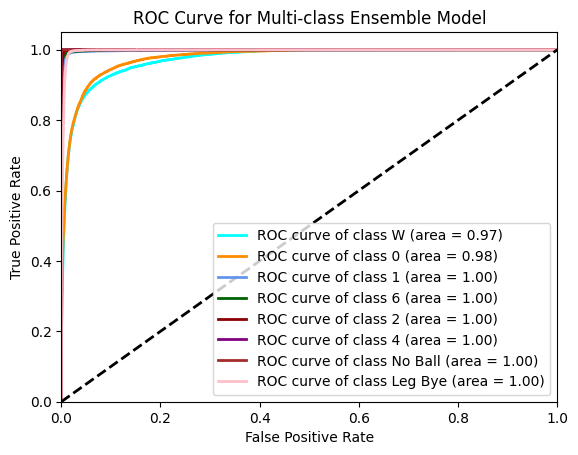


Macro AUC: 0.99


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Function to calculate target (includes runs, extras, and wickets)
def calculate_target(row):
    if row['is_wicket'] == 1:
        return 'W'
    elif row['extras_type'] == 1:  # Wide ball
        return 'Wide'
    elif row['extras_type'] == 2:  # No ball
        return 'No Ball'
    elif row['extras_type'] == 3:  # Leg Bye
        return 'Leg Bye'
    elif row['extras_type'] == 4:  # Bye
        return 'Bye'
    else:
        return str(int(row['batsman_runs']))

# Create target column
data['target'] = data.apply(calculate_target, axis=1)

# Get user inputs for match_id, inning, and over
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Validate the inning input: if it's not 1 or 2, throw an error
if inning not in [1, 2]:
    raise ValueError(f"Inning {inning} is invalid. Only innings 1 or 2 are allowed.")

# Filter the data to include only matches up to and including the specified match_id
historic_data = data[data['match_id'] <= match_id]

# Check if the specified over exists in the dataset
filtered_data = historic_data[(historic_data['match_id'] == match_id) &
                              (historic_data['inning'] == inning) &
                              (historic_data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Create feature and target datasets for all matches up to the specified match_id
    X = historic_data[features]
    y = historic_data['target']

    # Display the original distribution of target classes
    print("Original Target Distribution (up to and including match_id):")
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    classes = ['W', '0', '1', '6', '2', '4', 'No Ball', 'Leg Bye']
    class_data = {cls: data_combined[data_combined['target'] == cls] for cls in classes}

    # Determine the majority class size
    majority_size = max(len(class_data[cls]) for cls in classes)

    # Resample each class to the majority size
    resampled_data = [resample(class_data[cls], replace=True, n_samples=majority_size, random_state=42) for cls in classes]

    # Combine the resampled data
    data_balanced = pd.concat(resampled_data)

    # Separate features and target
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Display the resampled distribution of target classes
    print("\nResampled Target Distribution (balanced):")
    print(y_balanced.value_counts())

    # Normalize the feature data
    scaler = StandardScaler()
    X_balanced_scaled = scaler.fit_transform(X_balanced)

    # Encode target labels as single-label integers
    le = LabelEncoder()
    y_balanced_encoded = le.fit_transform(y_balanced)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_balanced_scaled, y_balanced_encoded, test_size=0.2, random_state=42)

    # Define models
    lr_model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

    # Create an ensemble model using VotingClassifier
    ensemble_model = VotingClassifier(estimators=[
        ('lr', lr_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ], voting='soft')

    # Train the ensemble model
    ensemble_model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred_prob = ensemble_model.predict_proba(X_test)

    # Convert predicted probabilities to class labels
    y_pred_class = ensemble_model.predict(X_test)

    # Decode the predicted and test labels back to original classes
    y_test_class = le.inverse_transform(y_test)
    y_pred_class_decoded = le.inverse_transform(y_pred_class)

    # Classification Report and Confusion Matrix
    print("\nClassification Report:")
    print(classification_report(y_test_class, y_pred_class_decoded))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_class, y_pred_class_decoded))

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        y_test_bin = np.where(y_test == i, 1, 0)
        y_pred_prob_bin = y_pred_prob[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_test_bin, y_pred_prob_bin)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'darkred', 'purple', 'brown', 'pink']
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-class Ensemble Model')
    plt.legend(loc="lower right")
    plt.show()

    # Compute AUC for the entire model
    macro_roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr", average="macro")
    print(f"\nMacro AUC: {macro_roc_auc:.2f}")


<ipython-input-58-4c95ea9c3be4>:13: DtypeWarning: Columns (49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed


Enter the Match ID: 1426311
Enter the Inning Number (1 or 2): 1
Enter the Over Number: 5
Original Target Distribution (up to and including match_id):
target
1          95954
0          78534
4          29676
2          16354
6          12938
W          12911
Bye         8318
Wide        3986
No Ball     1055
3            782
5             65
Leg Bye        2
Name: count, dtype: int64

Resampled Target Distribution (balanced):
target
W          95954
0          95954
1          95954
6          95954
2          95954
4          95954
No Ball    95954
Leg Bye    95954
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
9596/9596 - 65s - 7ms/step - accuracy: 0.5220 - loss: 1.0655 - val_accuracy: 0.5410 - val_loss: 1.0174
Epoch 2/20
9596/9596 - 72s - 7ms/step - accuracy: 0.5459 - loss: 1.0041 - val_accuracy: 0.5704 - val_loss: 0.9538
Epoch 3/20
9596/9596 - 98s - 10ms/step - accuracy: 0.5664 - loss: 0.9563 - val_accuracy: 0.5958 - val_loss: 0.8970
Epoch 4/20
9596/9596 - 51s - 5ms/step - accuracy: 0.5823 - loss: 0.9193 - val_accuracy: 0.6158 - val_loss: 0.8530
Epoch 5/20
9596/9596 - 89s - 9ms/step - accuracy: 0.5946 - loss: 0.8917 - val_accuracy: 0.6280 - val_loss: 0.8250
Epoch 6/20
9596/9596 - 59s - 6ms/step - accuracy: 0.6031 - loss: 0.8715 - val_accuracy: 0.6376 - val_loss: 0.7995
Epoch 7/20
9596/9596 - 62s - 6ms/step - accuracy: 0.6087 - loss: 0.8571 - val_accuracy: 0.6387 - val_loss: 0.7896
Epoch 8/20
9596/9596 - 94s - 10ms/step - accuracy: 0.6137 - loss: 0.8448 - val_accuracy: 0.6453 - val_loss: 0.7743
Epoch 9/20
9596/9596 - 62s - 6ms/step - accuracy: 0.6166 - loss: 0.8357 - val_accuracy

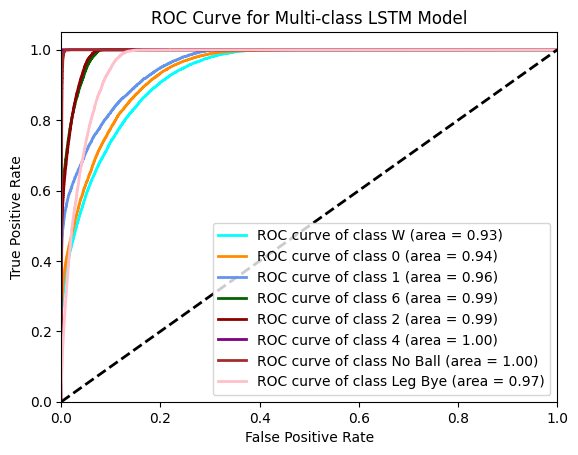


Macro AUC: 0.97


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Function to calculate target (includes runs, extras, and wickets)
def calculate_target(row):
    if row['is_wicket'] == 1:
        return 'W'
    elif row['extras_type'] == 1:  # Wide ball
        return 'Wide'
    elif row['extras_type'] == 2:  # No ball
        return 'No Ball'
    elif row['extras_type'] == 3:  # Leg Bye
        return 'Leg Bye'
    elif row['extras_type'] == 4:  # Bye
        return 'Bye'
    else:
        return str(int(row['batsman_runs']))

# Create target column
data['target'] = data.apply(calculate_target, axis=1)

# Get user inputs for match_id, inning, and over
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Validate the inning input: if it's not 1 or 2, throw an error
if inning not in [1, 2]:
    raise ValueError(f"Inning {inning} is invalid. Only innings 1 or 2 are allowed.")

# Filter the data to include only matches up to and including the specified match_id
historic_data = data[data['match_id'] <= match_id]

# Check if the specified over exists in the dataset
filtered_data = historic_data[(historic_data['match_id'] == match_id) &
                              (historic_data['inning'] == inning) &
                              (historic_data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Create feature and target datasets for all matches up to the specified match_id
    X = historic_data[features]
    y = historic_data['target']

    # Display the original distribution of target classes
    print("Original Target Distribution (up to and including match_id):")
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    classes = ['W', '0', '1', '6', '2', '4', 'No Ball', 'Leg Bye']
    class_data = {cls: data_combined[data_combined['target'] == cls] for cls in classes}

    # Determine the majority class size
    majority_size = max(len(class_data[cls]) for cls in classes)

    # Resample each class to the majority size
    resampled_data = [resample(class_data[cls], replace=True, n_samples=majority_size, random_state=42) for cls in classes]

    # Combine the resampled data
    data_balanced = pd.concat(resampled_data)

    # Separate features and target
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Display the resampled distribution of target classes
    print("\nResampled Target Distribution (balanced):")
    print(y_balanced.value_counts())

    # Normalize the feature data
    scaler = StandardScaler()
    X_balanced_scaled = scaler.fit_transform(X_balanced)

    # Encode target labels as single-label integers
    le = LabelEncoder()
    y_balanced_encoded = le.fit_transform(y_balanced)

    # Convert labels to one-hot encoding (required for LSTM)
    y_balanced_onehot = to_categorical(y_balanced_encoded)

    # Reshape input data to 3D array for LSTM: (samples, timesteps, features)
    # Here, we'll assume 1 timestep per sample, adjust if you want to sequence multiple overs/balls
    X_balanced_reshaped = X_balanced_scaled.reshape((X_balanced_scaled.shape[0], 1, X_balanced_scaled.shape[1]))

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced_onehot, test_size=0.2, random_state=42)

    # Define LSTM model
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(y_balanced_onehot.shape[1], activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=2)

    # Evaluate the model
    y_pred_prob = model.predict(X_test)

    # Convert predicted probabilities to class labels
    y_pred_class = np.argmax(y_pred_prob, axis=1)
    y_test_class = np.argmax(y_test, axis=1)

    # Decode the predicted and test labels back to original classes
    y_test_class_decoded = le.inverse_transform(y_test_class)
    y_pred_class_decoded = le.inverse_transform(y_pred_class)

    # Classification Report and Confusion Matrix
    print("\nClassification Report:")
    print(classification_report(y_test_class_decoded, y_pred_class_decoded))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_class_decoded, y_pred_class_decoded))

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        y_test_bin = np.where(y_test_class == i, 1, 0)
        y_pred_prob_bin = y_pred_prob[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_test_bin, y_pred_prob_bin)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'darkred', 'purple', 'brown', 'pink']
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-class LSTM Model')
    plt.legend(loc="lower right")
    plt.show()

    # Compute AUC for the entire model
    macro_roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr", average="macro")
    print(f"\nMacro AUC: {macro_roc_auc:.2f}")


<ipython-input-1-5a91bcb2221c>:11: DtypeWarning: Columns (49,50,51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed


Enter the Match ID: 1426311
Enter the Inning Number (1 or 2): 1
Enter the Over Number: 4
Original Target Distribution (up to and including match_id):
target
1          95954
0          78534
4          29676
2          16354
6          12938
W          12911
Bye         8318
Wide        3986
No Ball     1055
3            782
5             65
Leg Bye        2
Name: count, dtype: int64

Resampled Target Distribution (balanced):
target
W          95954
0          95954
1          95954
6          95954
2          95954
4          95954
No Ball    95954
Leg Bye    95954
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83     19122
           1       0.84      0.79      0.82     19182
           2       0.95      0.99      0.97     19272
           4       1.00      0.99      0.99     19190
           6       0.99      1.00      0.99     19239
     Leg Bye       1.00      1.00      1.00     1909

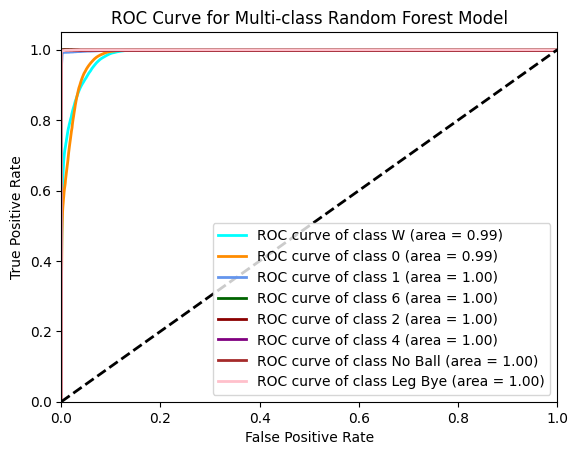


Macro AUC: 1.00


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
data = pd.read_csv('/content/inningsRemoved.csv')  # Adjust path as needed

# Select relevant columns for modeling
features = ['ball', 'batter', 'bowler', 'current_run_rate', 'wickets_in_hand',
            'recent_avg_runs', 'is_boundary', 'recent_boundary_rate', 'recent_runs_conceded',
            'recent_economy_rate', 'recent_wickets', 'partnership_runs',
            'venue_Highest Team Innings', 'venue_Lowest Team Innings',
            'venue_Highest Run Chase Achieved', 'venue_Average Runs per Wicket',
            'venue_Average Runs per Over', 'venue_Average Score Batting First',
            'cumulative_runs', 'overs_faced']

# Function to calculate target (includes runs, extras, and wickets)
def calculate_target(row):
    if row['is_wicket'] == 1:
        return 'W'
    elif row['extras_type'] == 1:  # Wide ball
        return 'Wide'
    elif row['extras_type'] == 2:  # No ball
        return 'No Ball'
    elif row['extras_type'] == 3:  # Leg Bye
        return 'Leg Bye'
    elif row['extras_type'] == 4:  # Bye
        return 'Bye'
    else:
        return str(int(row['batsman_runs']))

# Create target column
data['target'] = data.apply(calculate_target, axis=1)

# Get user inputs for match_id, inning, and over
match_id = int(input("Enter the Match ID: "))
inning = int(input("Enter the Inning Number (1 or 2): "))
over_number = int(input("Enter the Over Number: "))

# Validate the inning input: if it's not 1 or 2, throw an error
if inning not in [1, 2]:
    raise ValueError(f"Inning {inning} is invalid. Only innings 1 or 2 are allowed.")

# Filter the data to include only matches up to and including the specified match_id
historic_data = data[data['match_id'] <= match_id]

# Check if the specified over exists in the dataset
filtered_data = historic_data[(historic_data['match_id'] == match_id) &
                              (historic_data['inning'] == inning) &
                              (historic_data['over'] == over_number)]

if filtered_data.empty:
    print(f"Over {over_number} does not exist in Match ID {match_id}, Inning {inning}.")
else:
    # Create feature and target datasets for all matches up to the specified match_id
    X = historic_data[features]
    y = historic_data['target']

    # Display the original distribution of target classes
    print("Original Target Distribution (up to and including match_id):")
    print(y.value_counts())

    # Combine the feature and target data for resampling
    data_combined = pd.concat([X, y], axis=1)

    # Separate the data by classes
    classes = ['W', '0', '1', '6', '2', '4', 'No Ball', 'Leg Bye']
    class_data = {cls: data_combined[data_combined['target'] == cls] for cls in classes}

    # Determine the majority class size
    majority_size = max(len(class_data[cls]) for cls in classes)

    # Resample each class to the majority size
    resampled_data = [resample(class_data[cls], replace=True, n_samples=majority_size, random_state=42) for cls in classes]

    # Combine the resampled data
    data_balanced = pd.concat(resampled_data)

    # Separate features and target
    X_balanced = data_balanced.drop('target', axis=1)
    y_balanced = data_balanced['target']

    # Display the resampled distribution of target classes
    print("\nResampled Target Distribution (balanced):")
    print(y_balanced.value_counts())

    # Normalize the feature data
    scaler = StandardScaler()
    X_balanced_scaled = scaler.fit_transform(X_balanced)

    # Encode target labels as single-label integers
    le = LabelEncoder()
    y_balanced_encoded = le.fit_transform(y_balanced)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_balanced_scaled, y_balanced_encoded, test_size=0.2, random_state=42)

    # Define Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred_prob = rf_model.predict_proba(X_test)

    # Convert predicted probabilities to class labels
    y_pred_class = rf_model.predict(X_test)

    # Decode the predicted and test labels back to original classes
    y_test_class = le.inverse_transform(y_test)
    y_pred_class_decoded = le.inverse_transform(y_pred_class)

    # Classification Report and Confusion Matrix
    print("\nClassification Report:")
    print(classification_report(y_test_class, y_pred_class_decoded))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test_class, y_pred_class_decoded))

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(classes)):
        y_test_bin = np.where(y_test == i, 1, 0)
        y_pred_prob_bin = y_pred_prob[:, i]
        fpr[i], tpr[i], _ = roc_curve(y_test_bin, y_pred_prob_bin)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen', 'darkred', 'purple', 'brown', 'pink']
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-class Random Forest Model')
    plt.legend(loc="lower right")
    plt.show()

    # Compute AUC for the entire model
    macro_roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr", average="macro")
    print(f"\nMacro AUC: {macro_roc_auc:.2f}")
